# Notebook Focusing on Data Pre-processing for Brain Tumor Classification using 3D Images and 3D Convolutional Neural Networks 

⚠️ Note that this notebook is finished after the actual competition deadline ended. Work and personal life came in-between.

⚠️ Note that the results of the competition showed very poor performance - possibly indicating issues with the data or insignificant number of samples.  
Ref: https://www.kaggle.com/c/rsna-miccai-brain-tumor-radiogenomic-classification/discussion/284024  
Ref: https://www.kaggle.com/c/rsna-miccai-brain-tumor-radiogenomic-classification/discussion/279820

However, this is my first time implementing a 3D neural network so I thought it would be a good idea to document the outcome even though I stopped trying to get good results after I saw the outcome of the competition. Also the notebook proposed a method of extracting N number of slices in a consistent way from the largely varying 3D scan data. 

**Main points of this notebook** 
* I am interested in applying ML/neural networks in applications that can help people - Brain tumor classification is a prime example of that.
* Implementation of a 3D CNN using Keras
* The structure of MRI scan data had a huge variation in for instance: number of segments, size, intensities. This notebook implements an algorithm to extract N slices from the data in a consistent way. 


**Note:**
* Each sample comes with four different scan data:
    * Fluid Attenuated Inversion Recovery (FLAIR)
    * T1-weighted pre-contrast (T1w)
    * T1-weighted post-contrast (T1Gd)
    * T2-weighted (T2)
    
 
* This notebook uses the FLAIR type
* The intended approach (if the competition data would have been OK) would have been to train four different 3D-CNNs on the 4 different data types. Then apply a weighted average on the output of the four 3D-CNNs for the final classification. 


In [1]:
import numpy as np 
import pandas as pd 
import os
import glob
import re
import cv2

import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

from matplotlib import pyplot as plt
import math
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling3D,MaxPool3D,MaxPooling3D,AveragePooling3D,Dense, Flatten, Dropout, GlobalAveragePooling2D, Flatten, BatchNormalization, Conv3D
from random import shuffle
from sklearn.model_selection import train_test_split

from keras import backend as K
from textwrap import wrap

In [2]:
# Settings 
class settings:
    size = 128#64
    num_images =24
    learning_rate = 1e-4
    batchSize = 16
    numEpochs = 75
    debug = False
    debug_Nsamples = 30
    batch_size = 6

**Prepare the data:**

In [3]:
#Prepare the training dataframe
df = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")
testSub = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv")
df['BraTS21ID5'] = [format(x, '05d') for x in df.BraTS21ID]
data_path = '../input/rsna-miccai-brain-tumor-radiogenomic-classification'
train_folder = os.path.join(data_path, 'train')
df['imfolder'] = ['{:05d}'.format(s) for s in df['BraTS21ID']]
df['path'] = [os.path.join(train_folder, s) for s in df['imfolder']]

#Drop these four samples sice organizers pointed out they were not valid:
df.drop(df.index[df['BraTS21ID5'] == "00109"], inplace = True)
df.drop(df.index[df['BraTS21ID5'] == "00123"], inplace = True)
df.drop(df.index[df['BraTS21ID5'] == "00709"], inplace = True)

if settings.debug:
    df = df[0:settings.debug_Nsamples]

#Split into train and test set:
train_df, test_df = train_test_split(df, test_size=0.25)
train_df.iloc[0:5]

BraTS21ID  MGMT_value BraTS21ID5 imfolder  \
569        837           0      00837    00837   
530        778           0      00778    00778   
378        555           0      00555    00555   
492        718           1      00718    00718   
216        314           0      00314    00314   

                                                  path  
569  ../input/rsna-miccai-brain-tumor-radiogenomic-...  
530  ../input/rsna-miccai-brain-tumor-radiogenomic-...  
378  ../input/rsna-miccai-brain-tumor-radiogenomic-...  
492  ../input/rsna-miccai-brain-tumor-radiogenomic-...  
216  ../input/rsna-miccai-brain-tumor-radiogenomic-...

**Define function to rotate images:**

In [4]:
# Define function to rotate images
def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

**Function that loads the dicom images. Note that this function will read the rotation angle from the dicom and reverse the rotation.**

In [5]:
# Function to load dicom images
def load_dicom_image(path, img_size=settings.size, voi_lut=False, rotate_img=True):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    
    if not hasattr(dicom,'FlipAngle'):
        rotate=0
    else:
        rotate=np.int(dicom.FlipAngle)    
    #May apply "Value if Interest Look Up Table", ref: https://www.medicalconnections.co.uk/kb/lookup-tables/
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    if rotate_img:    
        if rotate > 0:
            data = rotate_image(data,-rotate)

    data = cv2.resize(data, (img_size, img_size))
    return data

**Function to stack images into 3D arrays from the dicom data. The different steps will be discussed and visualized below.**

In [6]:
def stack3Dimages(mri_type, df=df, plotExample = False):
    pick_idx = pd.DataFrame()
    stat_nFiles = np.zeros(len(df))
    stat_Intensity = []
    for k,d in enumerate(df["imfolder"]):
        if settings.debug:
            print('starting:' + str(d))
            print('k = ' + str(k))

        split="train"
        scan_id = str(d)
        files = sorted(glob.glob(f"{data_path}/{split}/{scan_id}/{mri_type}/*.dcm"), 
               key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])
        
        #img3d=np.zeros((0,0,0))
        img3d=[]
        for f in files:
            if len(img3d)==0:
                img3d = np.expand_dims(load_dicom_image(f,rotate_img=True),-1)
            else:
                img3d = np.append(img3d,np.expand_dims(load_dicom_image(f,rotate_img=True),-1),axis=-1)
                
        if settings.debug:
            print('shape img3d')
            print(np.shape(img3d))
            
        stat_nFiles[k] = np.shape(img3d)[2]
        if settings.debug:
            print("Len Files:")
            print(stat_nFiles[k])
        
        #Get the total intensity of each image
        img_int = np.zeros(np.shape(img3d)[2])
        for kk in range(np.shape(img3d)[2]):
            img_int[kk] = np.sum(np.abs(img3d[:,:,kk]))
            
        stat_Intensity.append(img_int)

        #plt.plot(img_int)
        idx_margin = 7 #Dont choose the first/last non-zero image
        idx = np.argmax(img_int)
        zero_idx = np.nonzero(img_int==0)[0]
        if np.sum(zero_idx<idx) == 0:
            start_idx = np.array([0])
        else:
            start_idx = zero_idx[zero_idx<idx]   

        start_idx = start_idx[-1]+idx_margin

        if np.sum(zero_idx>=idx) == 0:
            end_idx = np.array([len(img_int)])
        else:
            end_idx = zero_idx[zero_idx>=idx]
        end_idx = end_idx[0]-idx_margin
        idx_array = np.linspace(start_idx,end_idx,settings.num_images,dtype=int)

        if plotExample:
            plt.plot(img_int)
            plt.plot(idx_array,img_int[idx_array],'o')

        img_out = img3d[:,:,idx_array] #only works when single image is called, i.e. for illustration 
        pick_idx[scan_id] = idx_array
        
    return pick_idx, stat_nFiles, stat_Intensity, img_out
    #np.shape(img_out)

**Loop through the data, gather statistics, save the slice indices per sample (all explained below):**

In [7]:
pick_idx, stat_nFiles, stat_Intensity, img_out = stack3Dimages("FLAIR", df=df)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


**We can first look at the number of images available per sample. As seen, there is a huge spread in the number of images.**

Text(0, 0.5, 'Counts')

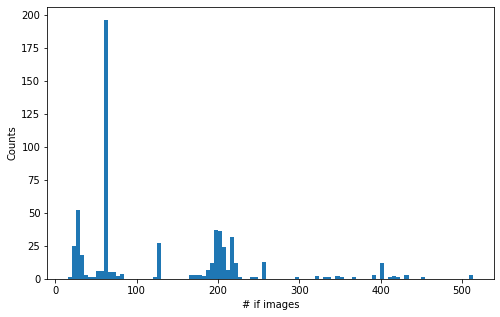

In [8]:
plt.figure(figsize=(8, 5))
plt.hist(stat_nFiles,100)
plt.xlabel('# if images')
plt.ylabel('Counts')
#plt.plot(stat_Intensity)   

**We can also look at the distribution of the intensity per image, i.e. by taking the sum of the intensity over all pixels per image. 
First, the intensities as a function of image number are plotted for all the samples. However, this is quite messy so also the sum of all intensities over all samples are plotted to get an envelope of the distribution of the intensities.**

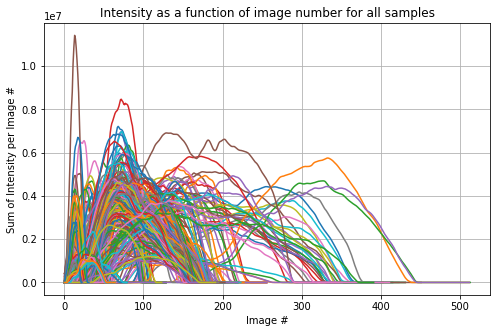

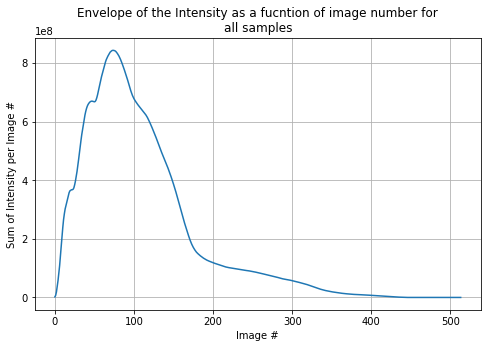

In [9]:
#pick_idx, stat_nFiles, stat_Intensity 

fig,axes = plt.subplots(figsize=(8, 5))
for intstat in stat_Intensity:
    plt.plot(intstat)
plt.grid('minor')
plt.xlabel('Image #')
plt.ylabel('Sum of Intensity per Image #')
plt.title('Intensity as a function of image number for all samples')

maxLen=0
for kk in stat_Intensity:
    if len(kk)>maxLen:
        maxLen=len(kk)
intSum = np.zeros(maxLen)

for kk in stat_Intensity:
    intSum[0:len(kk)] += kk 
    
fig,axes = plt.subplots(figsize=(8, 5))
axes.plot(intSum)
plt.grid('minor')
plt.xlabel('Image #')
plt.ylabel('Sum of Intensity per Image #')
#plt.title(
title = axes.set_title("\n".join(wrap("Envelope of the Intensity as a fucntion of image number for all samples", 60)))



**It is clear that a method to pre-process the data into 3D data with the size of NxNxM is needed. The approach taken here is to first find the sum of the pixel intensities per image. Then the first and last non-zero intensity images are found. A margin of, in this example 7 images, is also added since the images in the beginning and end of the sequences seem to contain very little information. In between these two values, N number of images are chosen with evenly distributed distances. See the examples below where the blue lines indicate the intensity per image and the orange dots indicate the selected images. Note that the x-axis (showing the number of images) is greatly varying.**

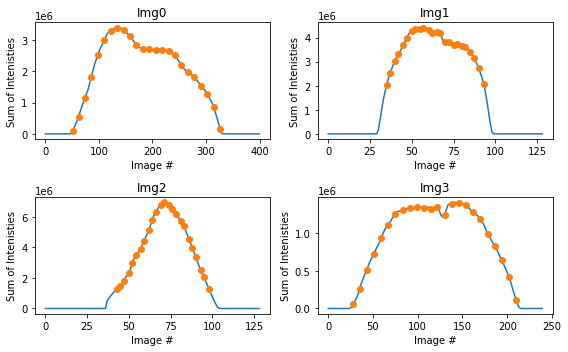

In [10]:
fig = plt.figure(figsize=(8, 5))
plt.subplot(221)
_,_,_,img0 = stack3Dimages('FLAIR', df=df.iloc[0:1], plotExample = True)
plt.xlabel('Image #')
plt.ylabel('Sum of Intenisties')
plt.title("Img0")
plt.subplot(222)
_,_,_,img1 = stack3Dimages('FLAIR', df=df.iloc[2:3], plotExample = True)
plt.xlabel('Image #')
plt.ylabel('Sum of Intenisties')
plt.title("Img1")
plt.subplot(223)
_,_,_,img2 = stack3Dimages('FLAIR', df=df.iloc[4:5], plotExample = True)
plt.xlabel('Image #')
plt.ylabel('Sum of Intenisties')
plt.title("Img2")
plt.subplot(224)
_,_,_,img3 = stack3Dimages('FLAIR', df=df.iloc[6:7], plotExample = True)
plt.xlabel('Image #')
plt.ylabel('Sum of Intenisties')
plt.title("Img3")
fig.tight_layout()

**The output image sequences illustrated for the four examples above:**

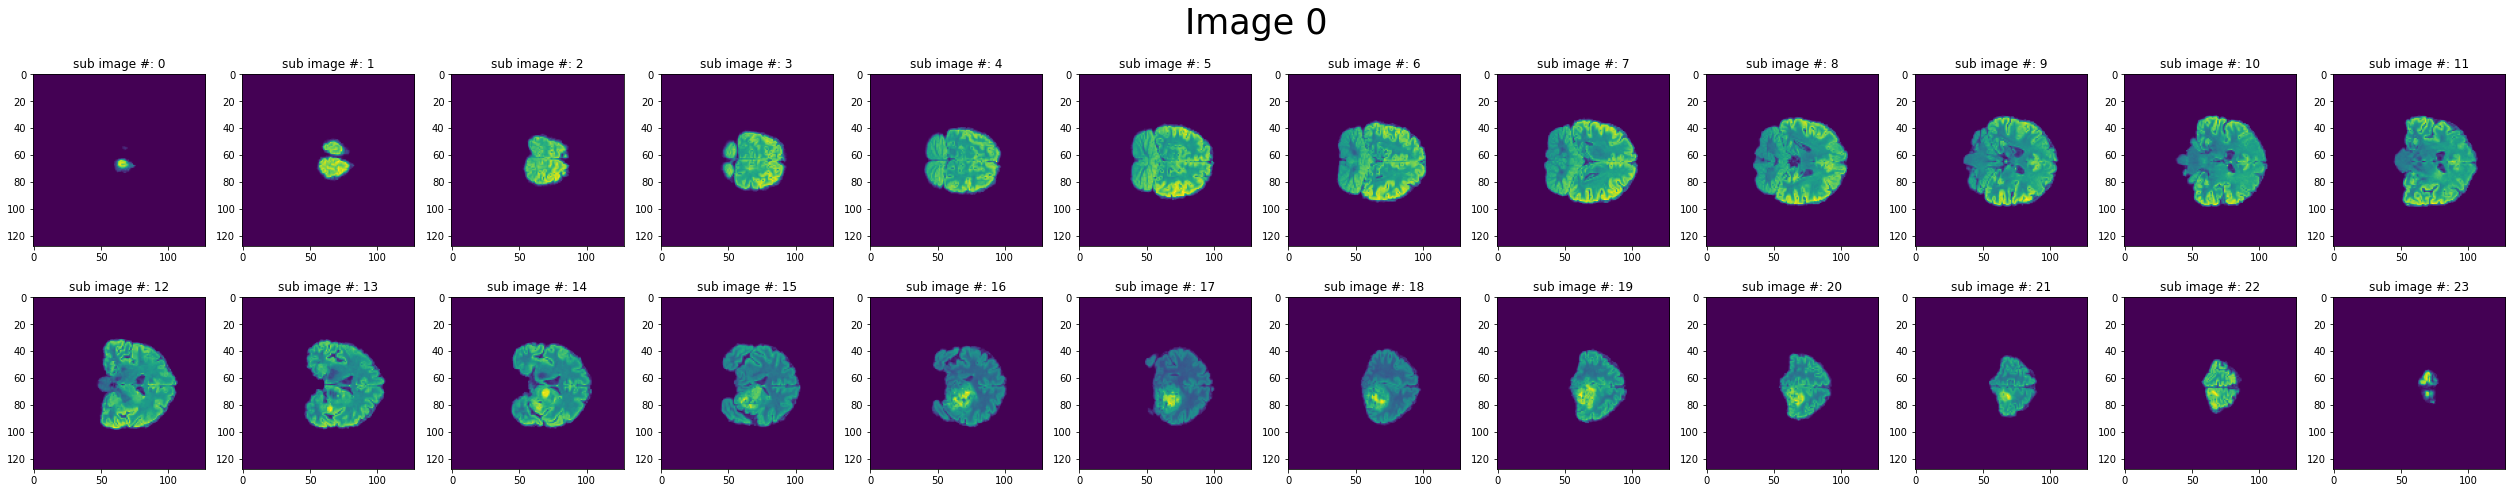

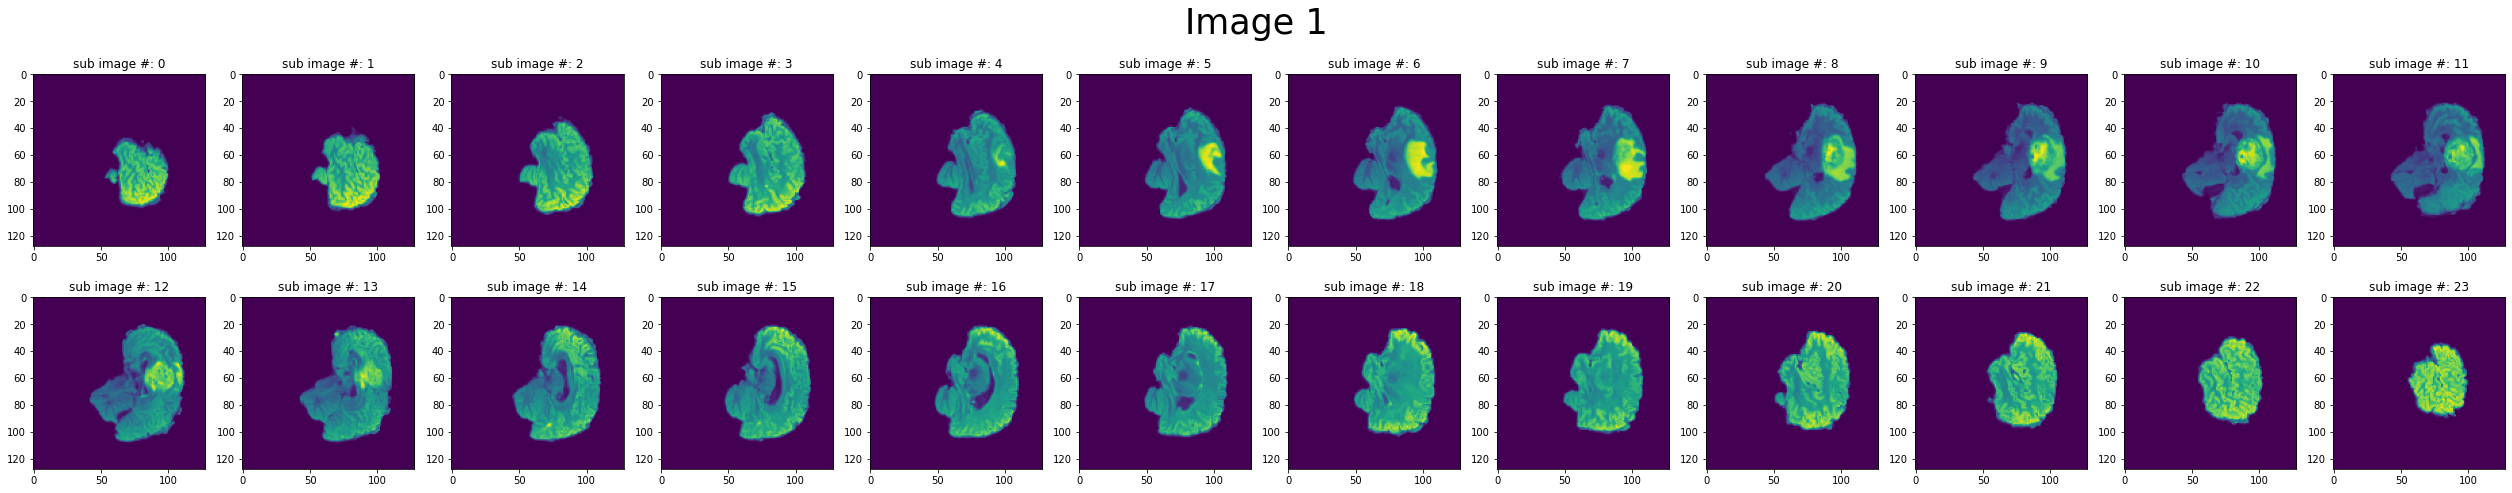

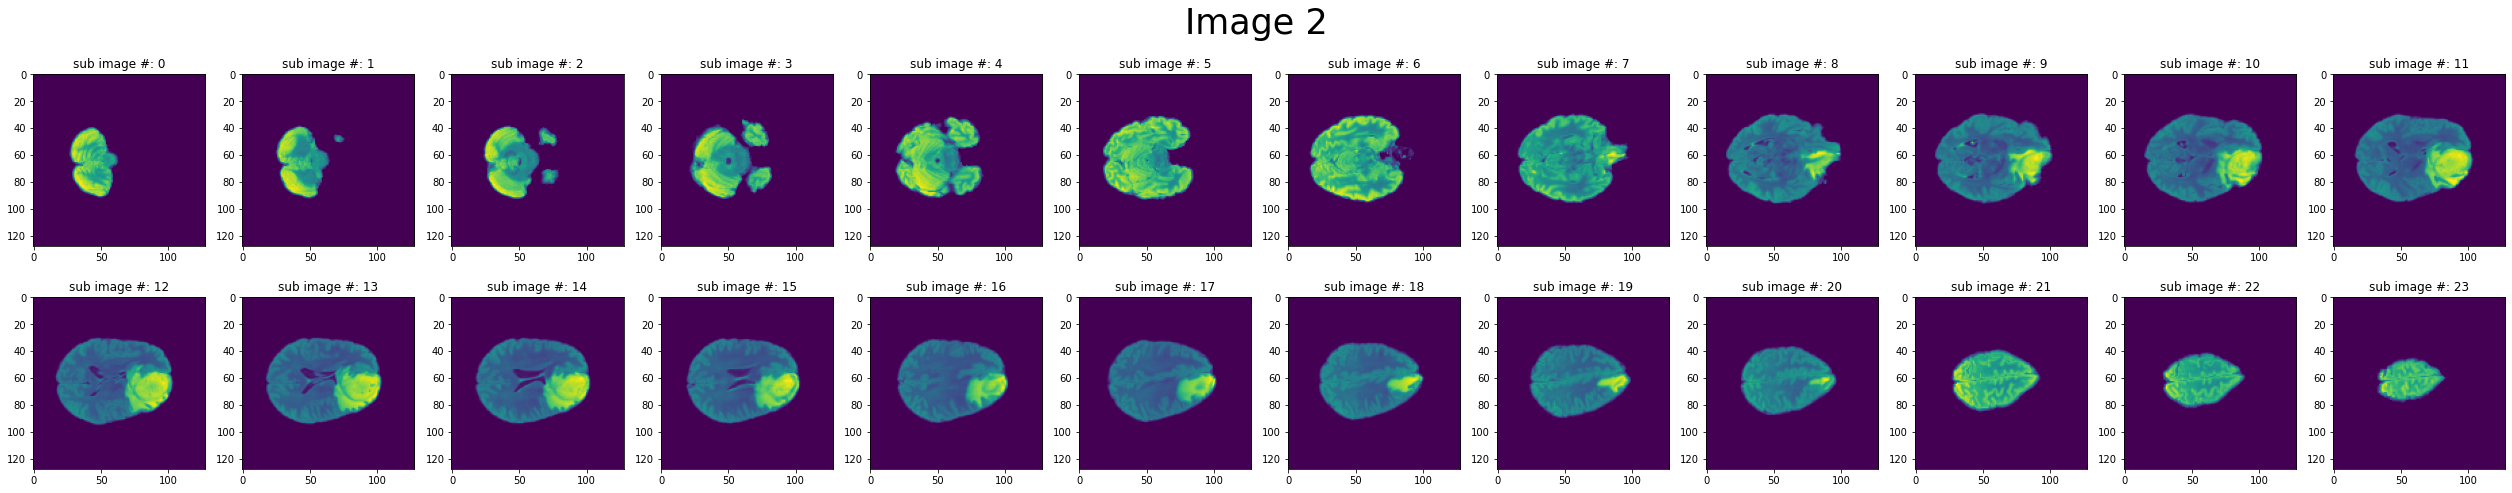

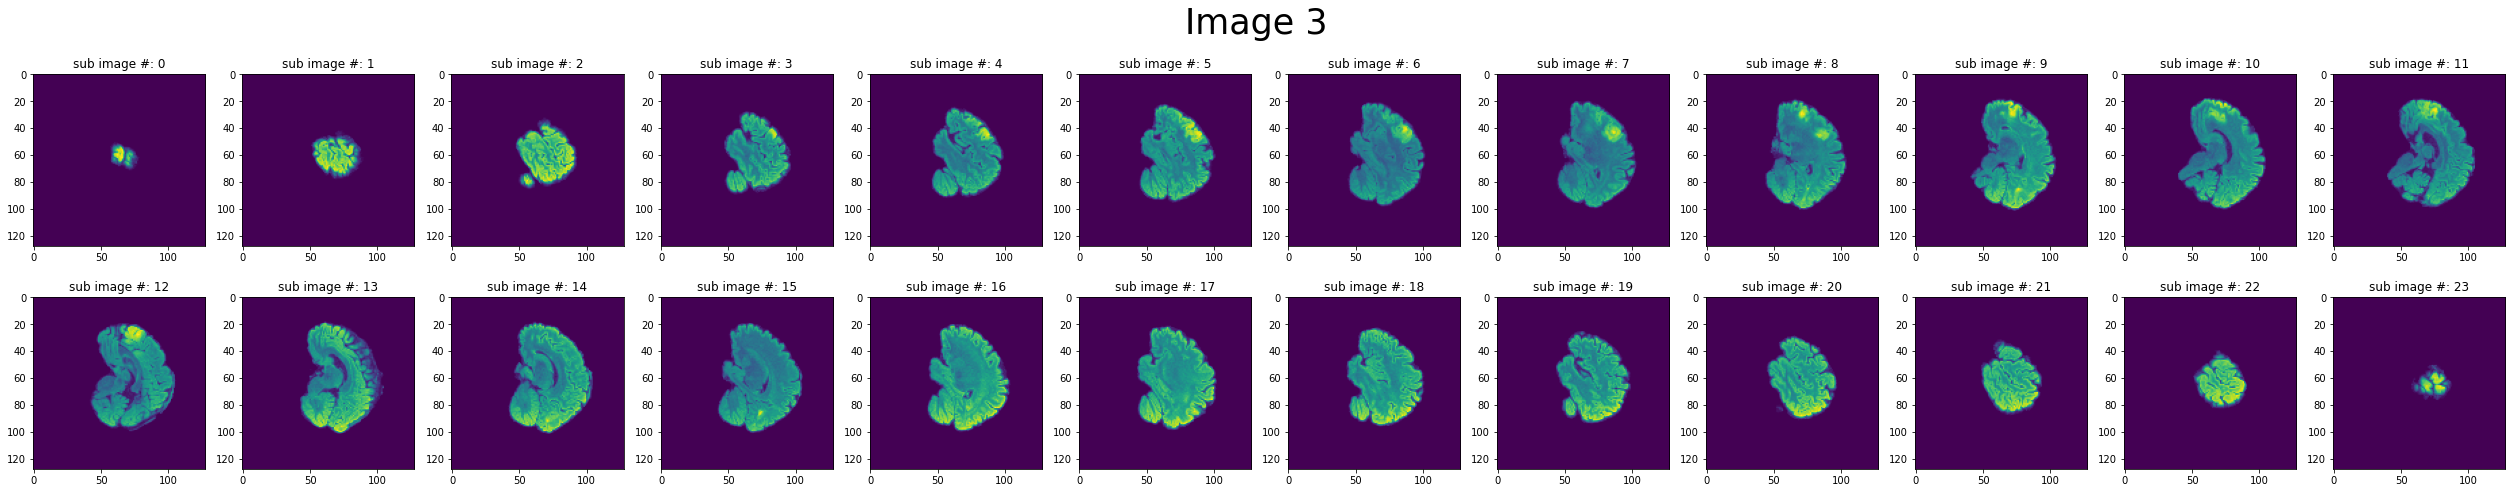

In [11]:
for k_img in range(4):
    fig = plt.figure(figsize=(35, 7))
    for k in range(settings.num_images):
        plt.subplot(2,int(settings.num_images/2),k+1)
        plt.imshow(eval("img"+str(k_img) +"[:,:,k]"))
        plt.title("sub image #: " +str(k))
    fig.suptitle("Image " +str(k_img), fontsize=35)
    fig.tight_layout()

**We now define a new image loader that uses the method described above to load images. Note that the there is not enough memory to store constructed images. Instead, the found indices are stored and used when loading new images to avoid having to run the image stacking algorithm over and over again.**

In [12]:
def load_dicom_images_3d_new(scan_id, num_imgs=settings.num_images, img_size=settings.size, mri_type="FLAIR", split="train", rotate_img=True,idx_array=pick_idx):

    files = sorted(glob.glob(f"{data_path}/{split}/{scan_id}/{mri_type}/*.dcm"), 
       key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])
    img3d=[]
    
    if scan_id in pick_idx: 
        #print('happens')
        img_out = np.stack([load_dicom_image(f, rotate_img=rotate_img) for f in [files[kk] for kk in pick_idx[scan_id]]]).T    
    else:
        for f in files:
            if len(img3d)==0:
                img3d = np.expand_dims(load_dicom_image(f,rotate_img=rotate_img),-1)
            else:
                img3d = np.append(img3d,np.expand_dims(load_dicom_image(f,rotate_img=rotate_img),-1),axis=-1)

        img_int = np.zeros(np.shape(img3d)[2])
        for k in range(np.shape(img3d)[2]):
            img_int[k] = np.sum(np.abs(img3d[:,:,k]))

        idx_margin = 4 #Dont choose the first/last non-zero image
        idx = np.argmax(img_int)
        zero_idx = np.nonzero(img_int==0)[0]
        if np.sum(zero_idx<idx) == 0:
            start_idx = np.array([0])
        else:
            start_idx = zero_idx[zero_idx<idx]   

        start_idx = start_idx[-1]+idx_margin

        if np.sum(zero_idx>=idx) == 0:
            end_idx = np.array([len(img_int)])
        else:
            end_idx = zero_idx[zero_idx>=idx]
        end_idx = end_idx[0]-idx_margin
        idx_array = np.linspace(start_idx,end_idx,NUM_IMAGES,dtype=int)

        img3d = np.array(img3d,dtype=float)
        img_out = img3d[:,:,idx_array]
    
    for k in range(np.shape(img_out)[2]):
        img_out[:,:,k] = img_out[:,:,k] - np.min(img_out[:,:,k])
        img_out[:,:,k] = img_out[:,:,k] / np.max(img_out[:,:,k])
    img_out = np.expand_dims(img_out,0)
    return(img_out)

**We then need to define a custom image loader to use the methods described above to load images.**

In [13]:
class customImageGenerator(tf.keras.utils.Sequence):
    def __init__(self,df,is_train=True,batch_size=settings.batch_size,shuffle=True):
        self.idx = df["BraTS21ID"].values
        self.paths = df["BraTS21ID5"].values
        self.y =  df["MGMT_value"].values
        self.is_train = is_train
        self.batch_size = batch_size
        self.shuffle = shuffle
    def __len__(self):
        return math.ceil(len(self.idx)/self.batch_size)
   
    def __getitem__(self,ids):
        id_path= self.paths[ids]
        batch_paths = self.paths[ids * self.batch_size:(ids + 1) * self.batch_size]
        
        if self.y is not None:
            batch_y = self.y[ids * self.batch_size: (ids + 1) * self.batch_size]
        
        if self.is_train:
            list_x =  [load_dicom_images_3d_new(x,split="train",idx_array=pick_idx) 
                       for x in batch_paths]       
            batch_X = np.stack(list_x, axis=0)
            batch_X =np.reshape(batch_X,(np.shape(batch_X)[0],settings.size,settings.size,settings.num_images,1))
            return batch_X,batch_y
        else:
            list_x =  [load_dicom_images_3d_new(x,split="test",idx_array=pick_idx) 
                       for x in batch_paths]
            batch_X = np.stack(list_x, axis=0)
            batch_X =np.reshape(batch_X,(np.shape(batch_X)[0],settings.size,settings.size,settings.num_images,1))
            return batch_X
    
    def on_epoch_end(self):
        if self.shuffle and self.is_train:
            shuffle(self.idx)

**Next, let's define the 3D CNN to be used for classification:**

Note: I played around a lot with different regularization methods. This seems to behave differently compared to conventional 2D CNNs. For instance, in some cases I saw issues with convergence with batch normalization. 

In [14]:
l2 = tf.keras.regularizers.l2(l2=0.01)
def return_model():
    model = Sequential()
    model.add(Input((settings.size,settings.size,settings.num_images,1)))
    model.add(Conv3D(64, kernel_size=(3,3, 3), strides=(1,1,1), activation='relu', kernel_initializer='he_uniform', name='conv3d_1',kernel_regularizer=l2))
    model.add(BatchNormalization(center=True, scale=True))
    model.add(Dropout(0.1))
    model.add(MaxPooling3D(pool_size=(2, 2, 1)))    
    model.add(Conv3D(64, kernel_size=(3, 3, 3), strides=(1,1,1), activation='relu', kernel_initializer='he_uniform',name='conv3d_2',kernel_regularizer=l2))
    model.add(BatchNormalization(center=True, scale=True)) 
    model.add(Dropout(0.1))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))    
    model.add(Conv3D(64, kernel_size=(3, 3, 3), strides=(1,1,1), activation='relu', kernel_initializer='he_uniform',name='conv3d_3',kernel_regularizer=l2))  

    model.add(GlobalAveragePooling3D())
    model.add(Dropout(0.25))
    model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [15]:
model = return_model()
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=settings.learning_rate), metrics=["accuracy"])
model.summary()

2021-11-07 10:58:16.466024: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 10:58:16.568188: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 10:58:16.568995: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 10:58:16.571657: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 126, 126, 22, 64)  1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 22, 64)  256       
_________________________________________________________________
dropout (Dropout)            (None, 126, 126, 22, 64)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 63, 63, 22, 64)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 61, 61, 20, 64)    110656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 20, 64)    256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 61, 61, 20, 64)    0

ead from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 10:58:18.565703: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15403 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


**Training the 3D CNN:**

In [16]:
#Currently not used, but kept if adaptive LR should be re-implemented:
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        LR = K.get_value(model.optimizer.learning_rate)   
        print("LR used previous epoch:" +str(LR))

my_callbacks = [ CustomCallback() ]

history = model.fit(
    customImageGenerator(train_df,batch_size=settings.batch_size, shuffle = True),
    validation_data=customImageGenerator(test_df,batch_size=settings.batch_size,shuffle = False),
    epochs=settings.numEpochs,
    shuffle=True,
    verbose=1,
    callbacks =[CustomCallback()]
)

2021-11-07 10:58:20.507309: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/75


2021-11-07 10:58:23.351456: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


73/73 [==============================] - 127s 2s/step - loss: 4.3321 - accuracy: 0.4954 - val_loss: 4.0970 - val_accuracy: 0.4726
LR used previous epoch:1e-04
Epoch 2/75
73/73 [==============================] - 68s 930ms/step - loss: 3.9176 - accuracy: 0.5138 - val_loss: 3.7212 - val_accuracy: 0.4726
LR used previous epoch:1e-04
Epoch 3/75
73/73 [==============================] - 67s 921ms/step - loss: 3.5743 - accuracy: 0.5206 - val_loss: 3.4007 - val_accuracy: 0.4726
LR used previous epoch:1e-04
Epoch 4/75
73/73 [==============================] - 72s 990ms/step - loss: 3.2719 - accuracy: 0.4794 - val_loss: 3.1257 - val_accuracy: 0.4726
LR used previous epoch:1e-04
Epoch 5/75
73/73 [==============================] - 72s 988ms/step - loss: 3.0142 - accuracy: 0.5069 - val_loss: 2.8874 - val_accuracy: 0.4658
LR used previous epoch:1e-04
Epoch 6/75
73/73 [==============================] - 70s 961ms/step - loss: 2.7891 - accuracy: 0.5344 - val_loss: 2.6820 - val_accuracy: 0.5274
LR used pr

**Plotting the loss and the accuracy:**

Text(0, 0.5, 'Accuracy')

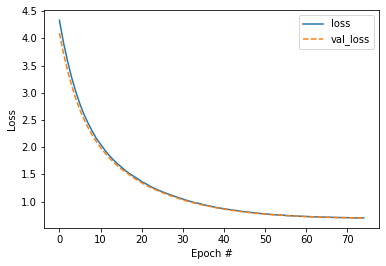

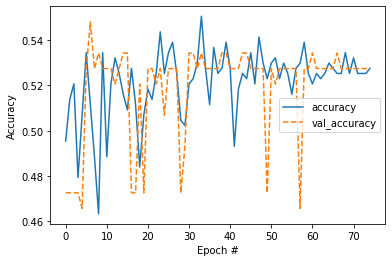

In [17]:
plt.figure()
plt.plot(history.history['loss'],'-',label='loss')
plt.plot(history.history['val_loss'],'--',label='val_loss')
plt.legend()
plt.xlabel('Epoch #')
plt.ylabel('Loss')

plt.figure()
plt.plot(history.history['accuracy'],'-',label='accuracy')
plt.plot(history.history['val_accuracy'],'--',label='val_accuracy')
plt.legend()
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')